# 📘 **Data importing**

In [ ]:
# @title **Google drive mount**

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title **Data Import**
import os
import shutil
import zipfile
from google.colab import drive
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
import csv
import numpy as np
from glob import glob
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm


# Replace this with your actual path to kaggle.json
kaggle_json_path = "/content/drive/MyDrive/kaggle.json"

# Make sure the directory exists
os.makedirs(os.path.dirname(kaggle_json_path), exist_ok=True)

# Set environment variable to use this path
os.environ['KAGGLE_CONFIG_DIR'] = os.path.dirname(kaggle_json_path)

# Optionally, check if the file exists
if os.path.isfile(kaggle_json_path):
    print(f"Kaggle API key found at {kaggle_json_path}")
else:
    print("Kaggle API key file not found. Please check the path.")

!kaggle datasets download -d suraj5424/concrete
with zipfile.ZipFile("/content/concrete.zip", 'r') as zip_ref:
    zip_ref.extractall("concrete")

Kaggle API key found at /content/drive/MyDrive/kaggle.json
Dataset URL: https://www.kaggle.com/datasets/suraj5424/concrete
License(s): unknown
 55% 128M/233M [00:00<00:00, 1.33GB/s]
100% 233M/233M [00:00<00:00, 817MB/s] 


In [ ]:
# @title **Data prepration**
non_crack_path = '/content/concrete/Data/non-crack'
crack_path     = '/content/concrete/Data/crack'

new_non_crack_path = '/content/concrete/Data/new_non_crack'
new_crack_path = '/content/concrete/Data/new_crack'

def add_prefix_to_filenames(folder_path, prefix):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            if not filename.startswith(prefix):
                new_filename = prefix + filename
                new_file_path = os.path.join(folder_path, new_filename)
                os.rename(file_path, new_file_path)

def move_files(src_folder, dst_folder, num_files):
    # Create destination folder if not exists
    os.makedirs(dst_folder, exist_ok=True)

    files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]
    files_to_move = files[:num_files]  # Take first num_files files

    for f in files_to_move:
        src_file = os.path.join(src_folder, f)
        dst_file = os.path.join(dst_folder, f)
        shutil.move(src_file, dst_file)

# Step 1: Add prefixes
add_prefix_to_filenames(non_crack_path, 'nc_')
add_prefix_to_filenames(crack_path, 'c_')

# Step 2: Move 5000 images from each folder to new folders test later using trained model
move_files(non_crack_path, new_non_crack_path, 5000)
move_files(crack_path, new_crack_path, 15000)

In [ ]:
# @title **File Counts and dataleak check**

def count_files(folder_path):
    """Count the number of files in a given folder."""
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

def get_files_set(folder_path):
    """Get a set of file names in a given folder."""
    return set(os.listdir(folder_path))

def print_file_counts(folder_paths, description):
    """Print file counts for a dictionary of folder paths."""
    for name, path in folder_paths.items():
        count = count_files(path)
        print(f'Files in {description} "{name}" folder: {count}')

# Paths to folders
folders = {
    'new_non_crack': '/content/concrete/Data/new_non_crack',
    'new_crack': '/content/concrete/Data/new_crack',
    'non_crack': '/content/concrete/Data/non-crack',
    'crack': '/content/concrete/Data/crack'
}

print("=== File Counts ===")
print_file_counts(folders, 'folder')

# Get sets of files for all folders
files_sets = {name: get_files_set(path) for name, path in folders.items()}

# Check for common files among all pairs of folders
common_files_overall = set()

folder_names = list(files_sets.keys())
for i in range(len(folder_names)):
    for j in range(i + 1, len(folder_names)):
        set1 = files_sets[folder_names[i]]
        set2 = files_sets[folder_names[j]]
        intersection = set1.intersection(set2)
        if intersection:
            print(f'Warning: Common files found between "{folder_names[i]}" and "{folder_names[j]}": {intersection}')
            common_files_overall.update(intersection)

if not common_files_overall:
    print("\nNo common files found among any of the folders. Perfect!")
else:
    print(f"\nTotal number of common files found among folders: {len(common_files_overall)}")

def list_image_files(folder_path, max_images=5, image_extensions=('.jpg', '.jpeg', '.png', '.gif')):
    files = os.listdir(folder_path)
    images = [file for file in files if file.lower().endswith(image_extensions)]
    print(f"Images in folder: {folder_path}")
    for image_name in images[:max_images]:
        print(f"- {image_name}")
    print()

def check_for_common_files(folder1, folder2, extensions=('.jpg', '.jpeg', '.png')):
    files1 = set(f.lower() for f in os.listdir(folder1) if f.lower().endswith(extensions))
    files2 = set(f.lower() for f in os.listdir(folder2) if f.lower().endswith(extensions))
    common_files = files1.intersection(files2)
    if common_files:
        print(f"⚠️ {len(common_files)} common file(s) found between the folders:")
        for file in sorted(common_files):
            print(f"  - {file}")
    else:
        print("✅ No common files found between the two folders.")
    print()

folder_non_crack = "/content/concrete/Data/non-crack"
folder_crack = "/content/concrete/Data/crack"

list_image_files(folder_non_crack)
list_image_files(folder_crack)
check_for_common_files(folder_non_crack, folder_crack)

=== File Counts ===
Files in folder "new_non_crack" folder: 5000
Files in folder "new_crack" folder: 15000
Files in folder "non_crack" folder: 15000
Files in folder "crack" folder: 5000

No common files found among any of the folders. Perfect!
Images in folder: /content/concrete/Data/non-crack
- nc_19953.jpg
- nc_14615.jpg
- nc_07428.jpg
- nc_10958.jpg
- nc_11008.jpg

Images in folder: /content/concrete/Data/crack
- c_00546.jpg
- c_12329_1.jpg
- c_02621.jpg
- c_01061.jpg
- c_01783.jpg

✅ No common files found between the two folders.



# 👉 **Model building**

In [ ]:
# @title **Utility fuctions**

import os
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from glob import glob
from PIL import Image
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import pandas as pd

# -------------------------------
# Dataset
# -------------------------------
class ConcreteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = glob(os.path.join(root_dir, "*.png")) + glob(os.path.join(root_dir, "*.jpg"))
        print(f"Found {len(self.files)} images in {root_dir}")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('L')
        if self.transform:
            img = self.transform(img)
        return img

# -------------------------------
# Variational Autoencoder
# -------------------------------
class ConvVAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(256*8*8, latent_dim)
        self.fc_logvar = nn.Linear(256*8*8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256*8*8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h_dec = self.fc_decode(z)
        recon = self.decoder(h_dec)
        return recon, mu, logvar

# -------------------------------
# Loss Function
# -------------------------------
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld


In [ ]:
# @title **Dataset and DataLoader Setup**

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

path_non_crack = '/content/concrete/Data/non-crack'
path_crack = '/content/concrete/Data/crack'

dataset_non = ConcreteDataset(path_non_crack, transform)
dataset_crack = ConcreteDataset(path_crack, transform)

# Split non-crack dataset
total_non = len(dataset_non)
train_size = int(0.8 * total_non)
val_size = int(0.1 * total_non)
test_size = total_non - train_size - val_size

g = torch.Generator().manual_seed(42)
train_non, val_non, test_non = random_split(dataset_non, [train_size, val_size, test_size], generator=g)

# Split crack dataset
total_crack = len(dataset_crack)
val_size_crack = int(0.1 * total_crack)
test_size_crack = total_crack - val_size_crack
val_crack, test_crack = random_split(dataset_crack, [val_size_crack, test_size_crack])

print(f"Train Non-crack: {len(train_non)}, Val Non-crack: {len(val_non)}, Test Non-crack: {len(test_non)}")
print(f"Val Crack: {len(val_crack)}, Test Crack: {len(test_crack)}")

batch_size = 32
dl_train = DataLoader(train_non, batch_size=batch_size, shuffle=True)
dl_val_non = DataLoader(val_non, batch_size=batch_size, shuffle=False)
dl_val_crack = DataLoader(val_crack, batch_size=batch_size, shuffle=False)
dl_test_non = DataLoader(test_non, batch_size=batch_size, shuffle=False)
dl_test_crack = DataLoader(test_crack, batch_size=batch_size, shuffle=False)

Found 15000 images in /content/concrete/Data/non-crack
Found 5000 images in /content/concrete/Data/crack
Train Non-crack: 12000, Val Non-crack: 1500, Test Non-crack: 1500
Val Crack: 500, Test Crack: 4500


In [ ]:
# @title **Training Loop**

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = ConvVAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 10
for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0
    for imgs in tqdm(dl_train, desc=f"Epoch {epoch}/{epochs}"):
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_non)
    print(f"Epoch {epoch}, Avg Loss per image: {avg_loss:.6f}")

torch.save(vae.state_dict(), "vae_concrete.pth")
print("Model saved to vae_concrete.pth")

Epoch 1/10: 100%|██████████| 375/375 [00:27<00:00, 13.54it/s]


Epoch 1, Avg Loss per image: 159.621553


Epoch 2/10: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


Epoch 2, Avg Loss per image: 102.172806


Epoch 3/10: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


Epoch 3, Avg Loss per image: 94.533696


Epoch 4/10: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


Epoch 4, Avg Loss per image: 92.550913


Epoch 5/10: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


Epoch 5, Avg Loss per image: 89.646809


Epoch 6/10: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


Epoch 6, Avg Loss per image: 88.278863


Epoch 7/10: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


Epoch 7, Avg Loss per image: 86.417217


Epoch 8/10: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


Epoch 8, Avg Loss per image: 83.771063


Epoch 9/10: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


Epoch 9, Avg Loss per image: 83.387051


Epoch 10/10: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


Epoch 10, Avg Loss per image: 83.131401
Model saved to vae_concrete.pth


In [ ]:
# @title **Model Evaluation**
loaded_vae = ConvVAE().to(device)
loaded_vae.load_state_dict(torch.load("vae_concrete.pth"))
loaded_vae.eval()

# Threshold tuning on val_non
errors = []
with torch.no_grad():
    for imgs in dl_val_non:
        imgs = imgs.to(device)
        recon, _, _ = loaded_vae(imgs)
        mse = nn.functional.mse_loss(recon, imgs, reduction='none')
        batch_errors = mse.view(mse.size(0), -1).mean(dim=1).cpu().numpy()
        errors.extend(batch_errors)
threshold = np.percentile(errors, 95)
print(f"Threshold (95th percentile): {threshold:.6f}")

# Test set evaluation
y_true, y_scores = [], []
with torch.no_grad():
    for imgs in dl_test_non:
        imgs = imgs.to(device)
        recon, _, _ = loaded_vae(imgs)
        mse = nn.functional.mse_loss(recon, imgs, reduction='none')
        y_scores.extend(mse.view(mse.size(0), -1).mean(dim=1).cpu().numpy())
        y_true.extend([0] * len(imgs))
    for imgs in dl_test_crack:
        imgs = imgs.to(device)
        recon, _, _ = loaded_vae(imgs)
        mse = nn.functional.mse_loss(recon, imgs, reduction='none')
        y_scores.extend(mse.view(mse.size(0), -1).mean(dim=1).cpu().numpy())
        y_true.extend([1] * len(imgs))

y_pred = [1 if s > threshold else 0 for s in y_scores]
print(f"ROC-AUC: {roc_auc_score(y_true, y_scores):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Threshold (95th percentile): 0.011993
ROC-AUC: 0.9905
Precision: 0.9812
Recall: 0.9649
F1 Score: 0.9730
Confusion Matrix:
 [[1417   83]
 [ 158 4342]]


# 👉 **Inference on test images**

In [ ]:
# @title **Inference & Prediction NON_CRACK_Concrete(Test)**

def predict_image(image_path, model, threshold):
    img = Image.open(image_path).convert('L')
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        recon, _, _ = model(img_t)
        error = nn.functional.mse_loss(recon, img_t, reduction='none').view(img_t.size(0), -1).mean().item()
    prediction = "CRACKED_Concrete" if error > threshold else "NON_CRACK_Concrete"
    return prediction, error

def predict_folder_and_save_csv(folder_path, csv_path='predictions.csv', limit=None):
    img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:limit]
    print(f"Found {len(img_files)} images in {folder_path}")
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['BNAME', 'SS FILE NAME', 'PREDICTION', 'ERROR'])
        for img_name in img_files:
            img_path = os.path.join(folder_path, img_name)
            pred, err = predict_image(img_path, vae, threshold)
            bname = os.path.basename(folder_path)
            writer.writerow([bname, img_name, pred, f"{err:.6f}"])

# Example usage
folder_path = "/content/concrete/Data/new_non_crack"
predict_folder_and_save_csv(folder_path, 'non_cracked_concrete_predictions.csv')

df = pd.read_csv('non_cracked_concrete_predictions.csv')
display(df[df["PREDICTION"] == "NON_CRACK_Concrete"])
display(df[df["PREDICTION"] == "CRACKED_Concrete"])

Found 5000 images in /content/concrete/Data/new_non_crack


BNAME  SS FILE NAME          PREDICTION     ERROR
0     new_non_crack  nc_11696.jpg  NON_CRACK_Concrete  0.000960
1     new_non_crack  nc_12982.jpg  NON_CRACK_Concrete  0.008032
2     new_non_crack  nc_16644.jpg  NON_CRACK_Concrete  0.003142
3     new_non_crack  nc_12593.jpg  NON_CRACK_Concrete  0.005966
5     new_non_crack  nc_17766.jpg  NON_CRACK_Concrete  0.001336
...             ...           ...                 ...       ...
4995  new_non_crack  nc_19716.jpg  NON_CRACK_Concrete  0.003270
4996  new_non_crack  nc_18021.jpg  NON_CRACK_Concrete  0.002284
4997  new_non_crack  nc_18452.jpg  NON_CRACK_Concrete  0.004370
4998  new_non_crack  nc_05892.jpg  NON_CRACK_Concrete  0.002288
4999  new_non_crack  nc_15256.jpg  NON_CRACK_Concrete  0.001350

[4735 rows x 4 columns]

BNAME  SS FILE NAME        PREDICTION     ERROR
4     new_non_crack  nc_15100.jpg  CRACKED_Concrete  0.015129
12    new_non_crack  nc_01984.jpg  CRACKED_Concrete  0.020088
28    new_non_crack  nc_13070.jpg  CRACKED_Concrete  0.012090
34    new_non_crack  nc_18976.jpg  CRACKED_Concrete  0.016635
65    new_non_crack  nc_10734.jpg  CRACKED_Concrete  0.012935
...             ...           ...               ...       ...
4929  new_non_crack  nc_01324.jpg  CRACKED_Concrete  0.012463
4946  new_non_crack  nc_12309.jpg  CRACKED_Concrete  0.016778
4966  new_non_crack  nc_18825.jpg  CRACKED_Concrete  0.013161
4974  new_non_crack  nc_09227.jpg  CRACKED_Concrete  0.026336
4991  new_non_crack  nc_00155.jpg  CRACKED_Concrete  0.015272

[265 rows x 4 columns]

In [ ]:
# @title **Inference & Prediction CRACKED_Concrete images(Test)**

from pickle import NONE
def predict_image(image_path, model, threshold):
    img = Image.open(image_path).convert('L')
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        recon, _, _ = model(img_t)
        error = nn.functional.mse_loss(recon, img_t, reduction='none').view(img_t.size(0), -1).mean().item()
    prediction = "CRACKED_Concrete" if error > threshold else "NON_CRACK_Concrete"
    return prediction, error

def predict_folder_and_save_csv(folder_path, csv_path='predictions.csv', limit=None):
    img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:limit]
    print(f"Found {len(img_files)} images in {folder_path}")
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['BNAME', 'SS FILE NAME', 'PREDICTION', 'ERROR'])
        for img_name in img_files:
            img_path = os.path.join(folder_path, img_name)
            pred, err = predict_image(img_path, vae, threshold)
            bname = os.path.basename(folder_path)
            writer.writerow([bname, img_name, pred, f"{err:.6f}"])

# Example usage
folder_path = "/content/concrete/Data/new_crack"
predict_folder_and_save_csv(folder_path, 'cracked_concrete_predictions.csv')

df = pd.read_csv('cracked_concrete_predictions.csv')
display(df[df["PREDICTION"] == "CRACKED_Concrete"])
display(df[df["PREDICTION"] == "NON_CRACK_Concrete"])

Found 15000 images in /content/concrete/Data/new_crack


BNAME   SS FILE NAME        PREDICTION     ERROR
0      new_crack  c_11850_1.jpg  CRACKED_Concrete  0.046984
1      new_crack    c_08873.jpg  CRACKED_Concrete  0.089416
2      new_crack    c_09243.jpg  CRACKED_Concrete  0.085258
3      new_crack  c_12354_1.jpg  CRACKED_Concrete  0.023608
4      new_crack  c_12004_1.jpg  CRACKED_Concrete  0.031086
...          ...            ...               ...       ...
14995  new_crack    c_08400.jpg  CRACKED_Concrete  0.024406
14996  new_crack    c_08367.jpg  CRACKED_Concrete  0.039392
14997  new_crack    c_04970.jpg  CRACKED_Concrete  0.019792
14998  new_crack  c_13964_1.jpg  CRACKED_Concrete  0.068544
14999  new_crack  c_17615_1.jpg  CRACKED_Concrete  0.039205

[14475 rows x 4 columns]

BNAME   SS FILE NAME          PREDICTION     ERROR
9      new_crack    c_05560.jpg  NON_CRACK_Concrete  0.005681
61     new_crack    c_05559.jpg  NON_CRACK_Concrete  0.005865
88     new_crack    c_01036.jpg  NON_CRACK_Concrete  0.011263
95     new_crack    c_05321.jpg  NON_CRACK_Concrete  0.008044
108    new_crack    c_05422.jpg  NON_CRACK_Concrete  0.009456
...          ...            ...                 ...       ...
14757  new_crack    c_05481.jpg  NON_CRACK_Concrete  0.009616
14826  new_crack    c_04900.jpg  NON_CRACK_Concrete  0.010303
14827  new_crack    c_05454.jpg  NON_CRACK_Concrete  0.006863
14951  new_crack  c_18775_1.jpg  NON_CRACK_Concrete  0.006722
14956  new_crack  c_15388_1.jpg  NON_CRACK_Concrete  0.011661

[525 rows x 4 columns]

# 👉 **Result Visualisation**

In [ ]:
# @title **Visualisation functions**
model_path = '/content/vae_concrete.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_vae = ConvVAE().to(device)
loaded_vae.load_state_dict(torch.load(model_path))
loaded_vae.eval()
print("Model loaded for visualization")

num_samples = 5

# ---------------------------
# 1. Visualize Reconstructions
# ---------------------------
def visualize_reconstructions(dataloader, model, threshold, device, title, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    # Reserve space for suptitle and bottom text
    fig.suptitle(title, fontsize=18, y=0.95)

    with torch.no_grad():
        for idx, images in enumerate(dataloader):
            if idx >= num_samples:
                break

            images = images.to(device)
            reconstructions, _, _ = model(images)
            mse = torch.nn.functional.mse_loss(reconstructions, images, reduction='none')
            batch_errors = mse.view(mse.size(0), -1).mean(dim=1).cpu().numpy()

            original = images[0].cpu().squeeze().numpy() * 0.5 + 0.5
            recon = reconstructions[0].cpu().squeeze().numpy() * 0.5 + 0.5
            error_map = np.abs(original - recon)

            status = "ANOMALY (CRACK)" if batch_errors[0] > threshold else "NORMAL"
            color = "red" if batch_errors[0] > threshold else "green"

            # Original
            axes[idx, 0].imshow(original, cmap='gray')
            axes[idx, 0].set_title(f'Original\nError: {batch_errors[0]:.6f}', fontsize=12, pad=3)
            axes[idx, 0].axis('off')

            # Reconstruction
            axes[idx, 1].imshow(recon, cmap='gray')
            axes[idx, 1].set_title('Reconstructed', fontsize=12, pad=3)
            axes[idx, 1].axis('off')

            # Error map
            im = axes[idx, 2].imshow(error_map, cmap='hot')
            axes[idx, 2].set_title('Error Map', fontsize=12, pad=3)
            axes[idx, 2].axis('off')
            fig.colorbar(im, ax=axes[idx, 2], fraction=0.046, pad=0.04)

            # Place status below reconstruction image, centered, no overlap
            axes[idx, 1].text(0.5, -0.3, f'Status: {status}',
                              transform=axes[idx, 1].transAxes,
                              ha='center', fontsize=12, color=color, weight='bold')

    plt.tight_layout(rect=[0, 0.05, 1, 0.9])  # Reserve space for suptitle and bottom text
    plt.show()


# ---------------------------
# 2. Visualize Correct Predictions
# ---------------------------
def visualize_correct_predictions(dataloader, model, threshold, device, title, is_anomaly, num_samples=10):
    model.eval()
    correct_samples = []

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            reconstructions, _, _ = model(images)
            mse = torch.nn.functional.mse_loss(reconstructions, images, reduction='none')
            errors = mse.view(mse.size(0), -1).mean(dim=1).cpu().numpy()

            for i in range(len(images)):
                if (is_anomaly and errors[i] > threshold) or (not is_anomaly and errors[i] <= threshold):
                    correct_samples.append({
                        'original': images[i].cpu().squeeze().numpy(),
                        'recon': reconstructions[i].cpu().squeeze().numpy(),
                        'error': errors[i]
                    })
                    if len(correct_samples) >= num_samples:
                        break
            if len(correct_samples) >= num_samples:
                break

    if not correct_samples:
        print(f"No correct predictions found for {title}")
        return

    fig, axes = plt.subplots(len(correct_samples), 3, figsize=(15, 3 * len(correct_samples)))
    fig.suptitle(f"Correct Predictions: {title}", fontsize=16, y=1.02)

    for i, sample in enumerate(correct_samples):
        original = sample['original'] * 0.5 + 0.5
        recon = sample['recon'] * 0.5 + 0.5
        error_map = np.abs(original - recon)

        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title(f'Original\nError: {sample["error"]:.6f}', fontsize=12, pad=3)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(recon, cmap='gray')
        axes[i, 1].set_title('Reconstructed', fontsize=12, pad=3)
        axes[i, 1].axis('off')

        im = axes[i, 2].imshow(error_map, cmap='hot')
        axes[i, 2].set_title('Error Map', fontsize=12, pad=3)
        axes[i, 2].axis('off')
        fig.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

        pred_type = "Correctly Detected Crack" if is_anomaly else "Correctly Identified Normal"
        # Place label below reconstructed image, centered, colored green
        axes[i, 1].text(0.5, -0.25, f"Sample {i + 1}: {pred_type}",
                        transform=axes[i, 1].transAxes,
                        ha='center', fontsize=14, color='green', weight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ---------------------------
# 3. Analyze Failure Cases
# ---------------------------
def analyze_failures(dataloader, model, threshold, device, title, is_anomaly):
    model.eval()
    failures = []

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            reconstructions, _, _ = model(images)
            mse = torch.nn.functional.mse_loss(reconstructions, images, reduction='none')
            errors = mse.view(mse.size(0), -1).mean(dim=1).cpu().numpy()

            for i in range(len(images)):
                if (is_anomaly and errors[i] <= threshold) or (not is_anomaly and errors[i] > threshold):
                    failures.append({
                        'original': images[i].cpu().squeeze().numpy(),
                        'recon': reconstructions[i].cpu().squeeze().numpy(),
                        'error': errors[i]
                    })
                    if len(failures) >= 5:
                        break
            if len(failures) >= 5:
                break

    if not failures:
        print(f"No failure cases found for {title}")
        return

    fig, axes = plt.subplots(len(failures), 3, figsize=(15, 3*len(failures)))
    fig.suptitle(f"Failure Cases: {title}", fontsize=16, y=1.02)

    for i, failure in enumerate(failures):
        original = failure['original'] * 0.5 + 0.5
        recon = failure['recon'] * 0.5 + 0.5
        error_map = np.abs(original - recon)

        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title(f'Original\nError: {failure["error"]:.6f}', fontsize=12, pad=3)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(recon, cmap='gray')
        axes[i, 1].set_title('Reconstructed', fontsize=12, pad=3)
        axes[i, 1].axis('off')

        im = axes[i, 2].imshow(error_map, cmap='hot')
        axes[i, 2].set_title('Error Map', fontsize=12, pad=3)
        axes[i, 2].axis('off')
        fig.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

        failure_type = "False Negative (Missed Crack)" if is_anomaly else "False Positive (False Alarm)"
        # Place failure label below reconstructed image, centered, colored red
        axes[i, 1].text(0.5, -0.25, f"Failure {i+1}: {failure_type}",
                        transform=axes[i, 1].transAxes,
                        ha='center', fontsize=14, color='red', weight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Model loaded for visualization



📌 Visualizing Non-Cracked (Normal) Reconstructions:


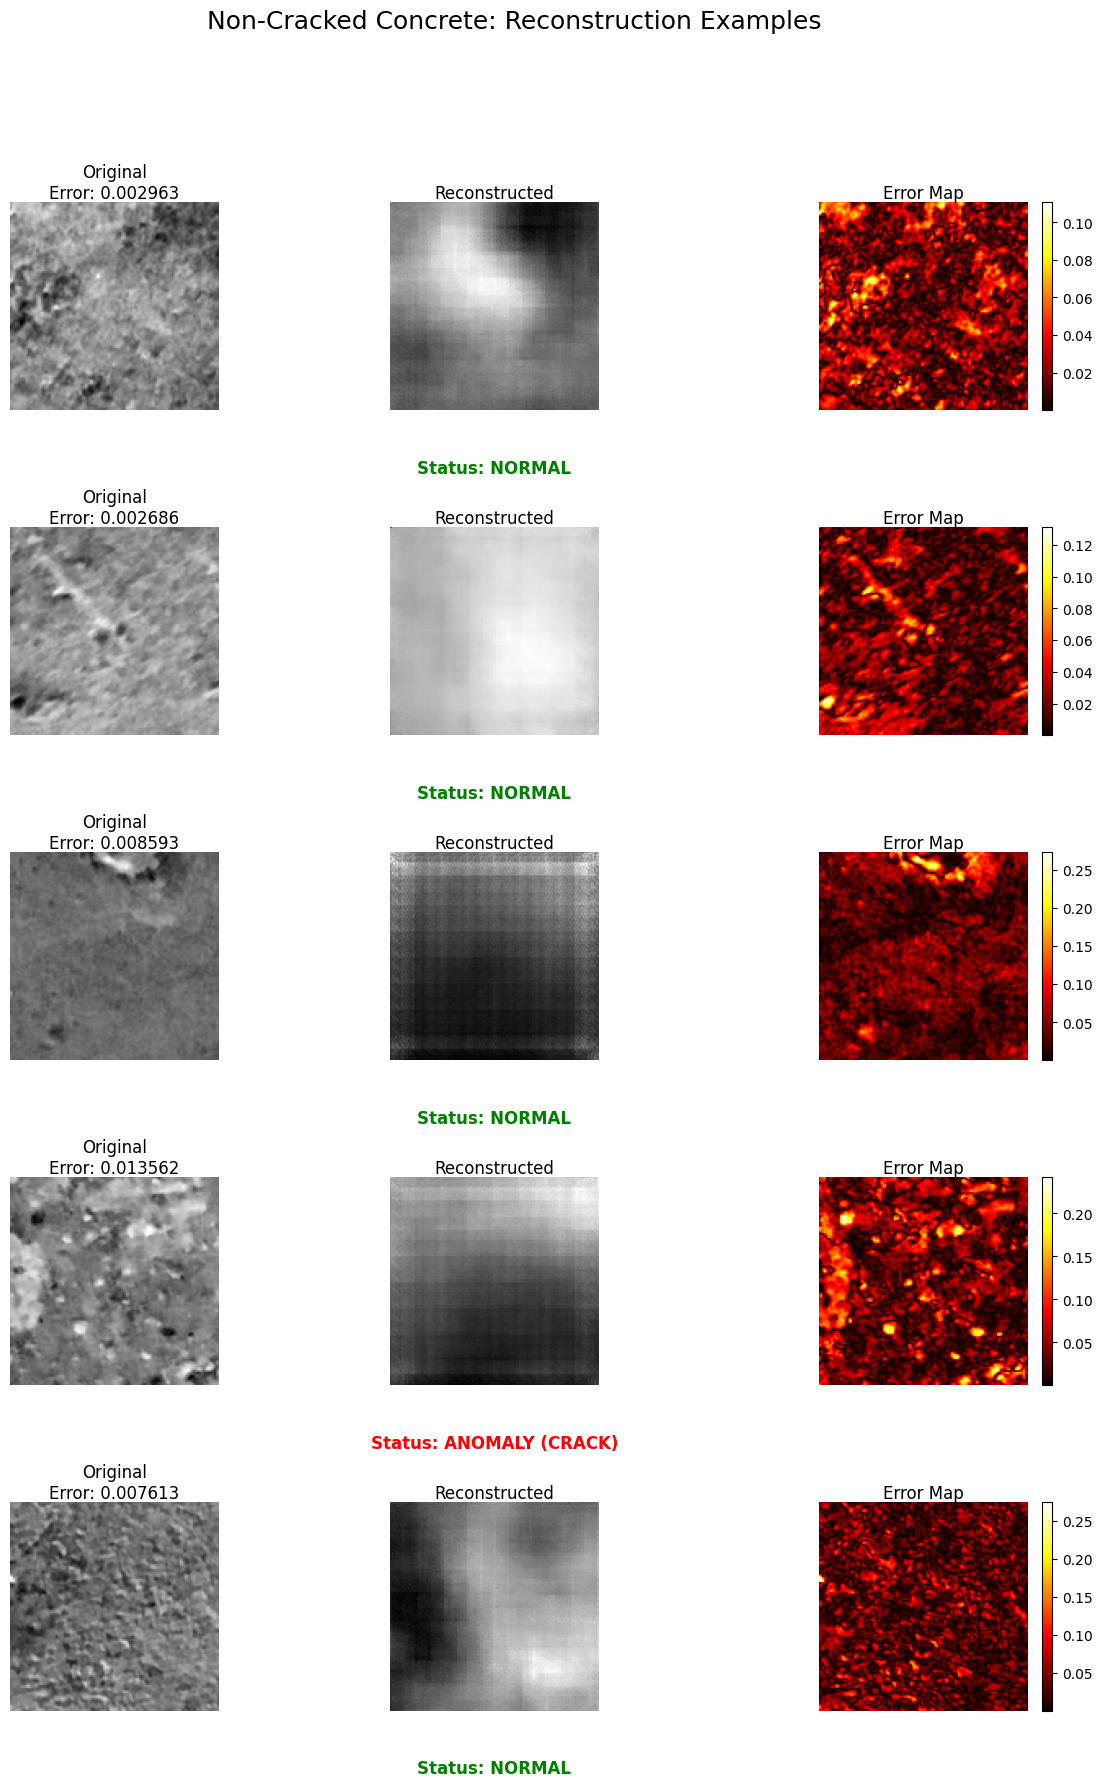

In [ ]:
# @title **Visualizing Non-Cracked (Normal) Reconstructions**
print("\n📌 Visualizing Non-Cracked (Normal) Reconstructions:")
visualize_reconstructions(dl_test_non, loaded_vae, threshold, device,
                         "Non-Cracked Concrete: Reconstruction Examples", num_samples)



📌 Visualizing Cracked (Anomaly) Reconstructions:


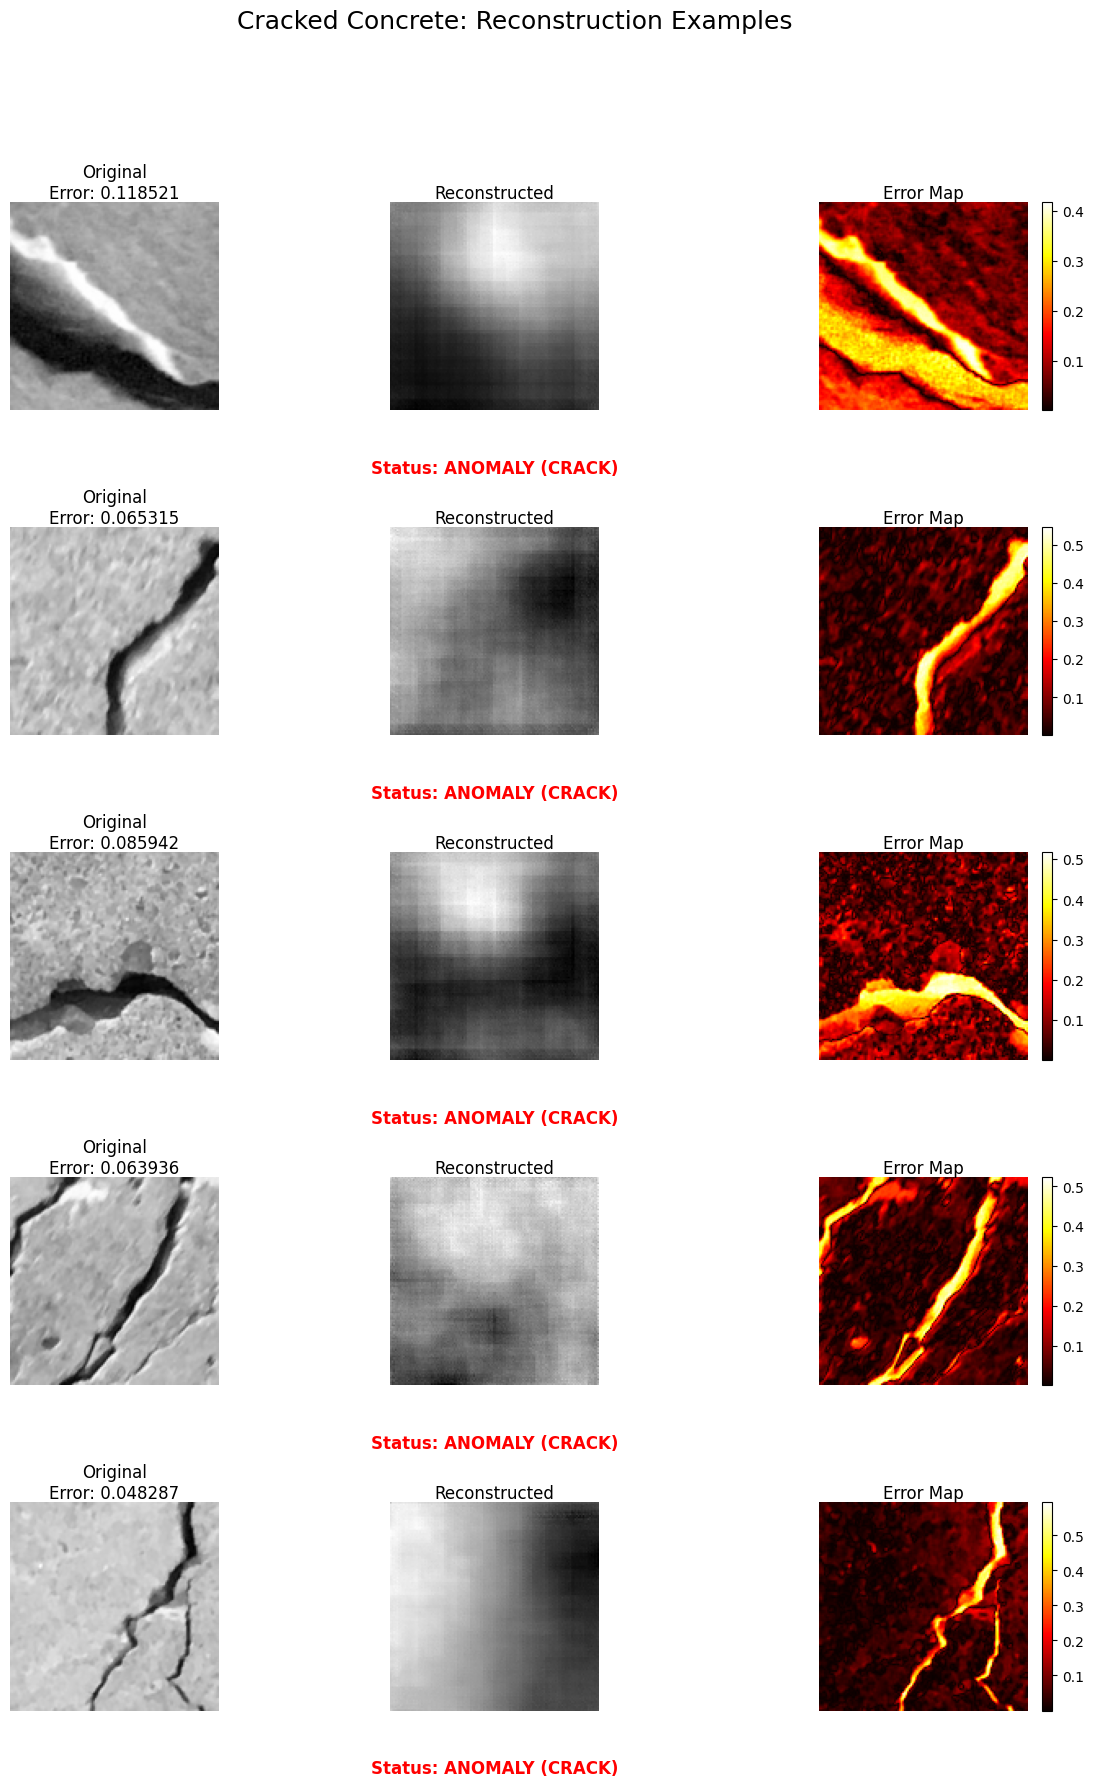

In [ ]:
# @title **Visualizing Cracked (Anomaly) Reconstructions**
print("\n📌 Visualizing Cracked (Anomaly) Reconstructions:")
visualize_reconstructions(dl_test_crack, loaded_vae, threshold, device,
                         "Cracked Concrete: Reconstruction Examples", num_samples)


📌 Visualizing Correctly Predicted Non-Cracked Examples:


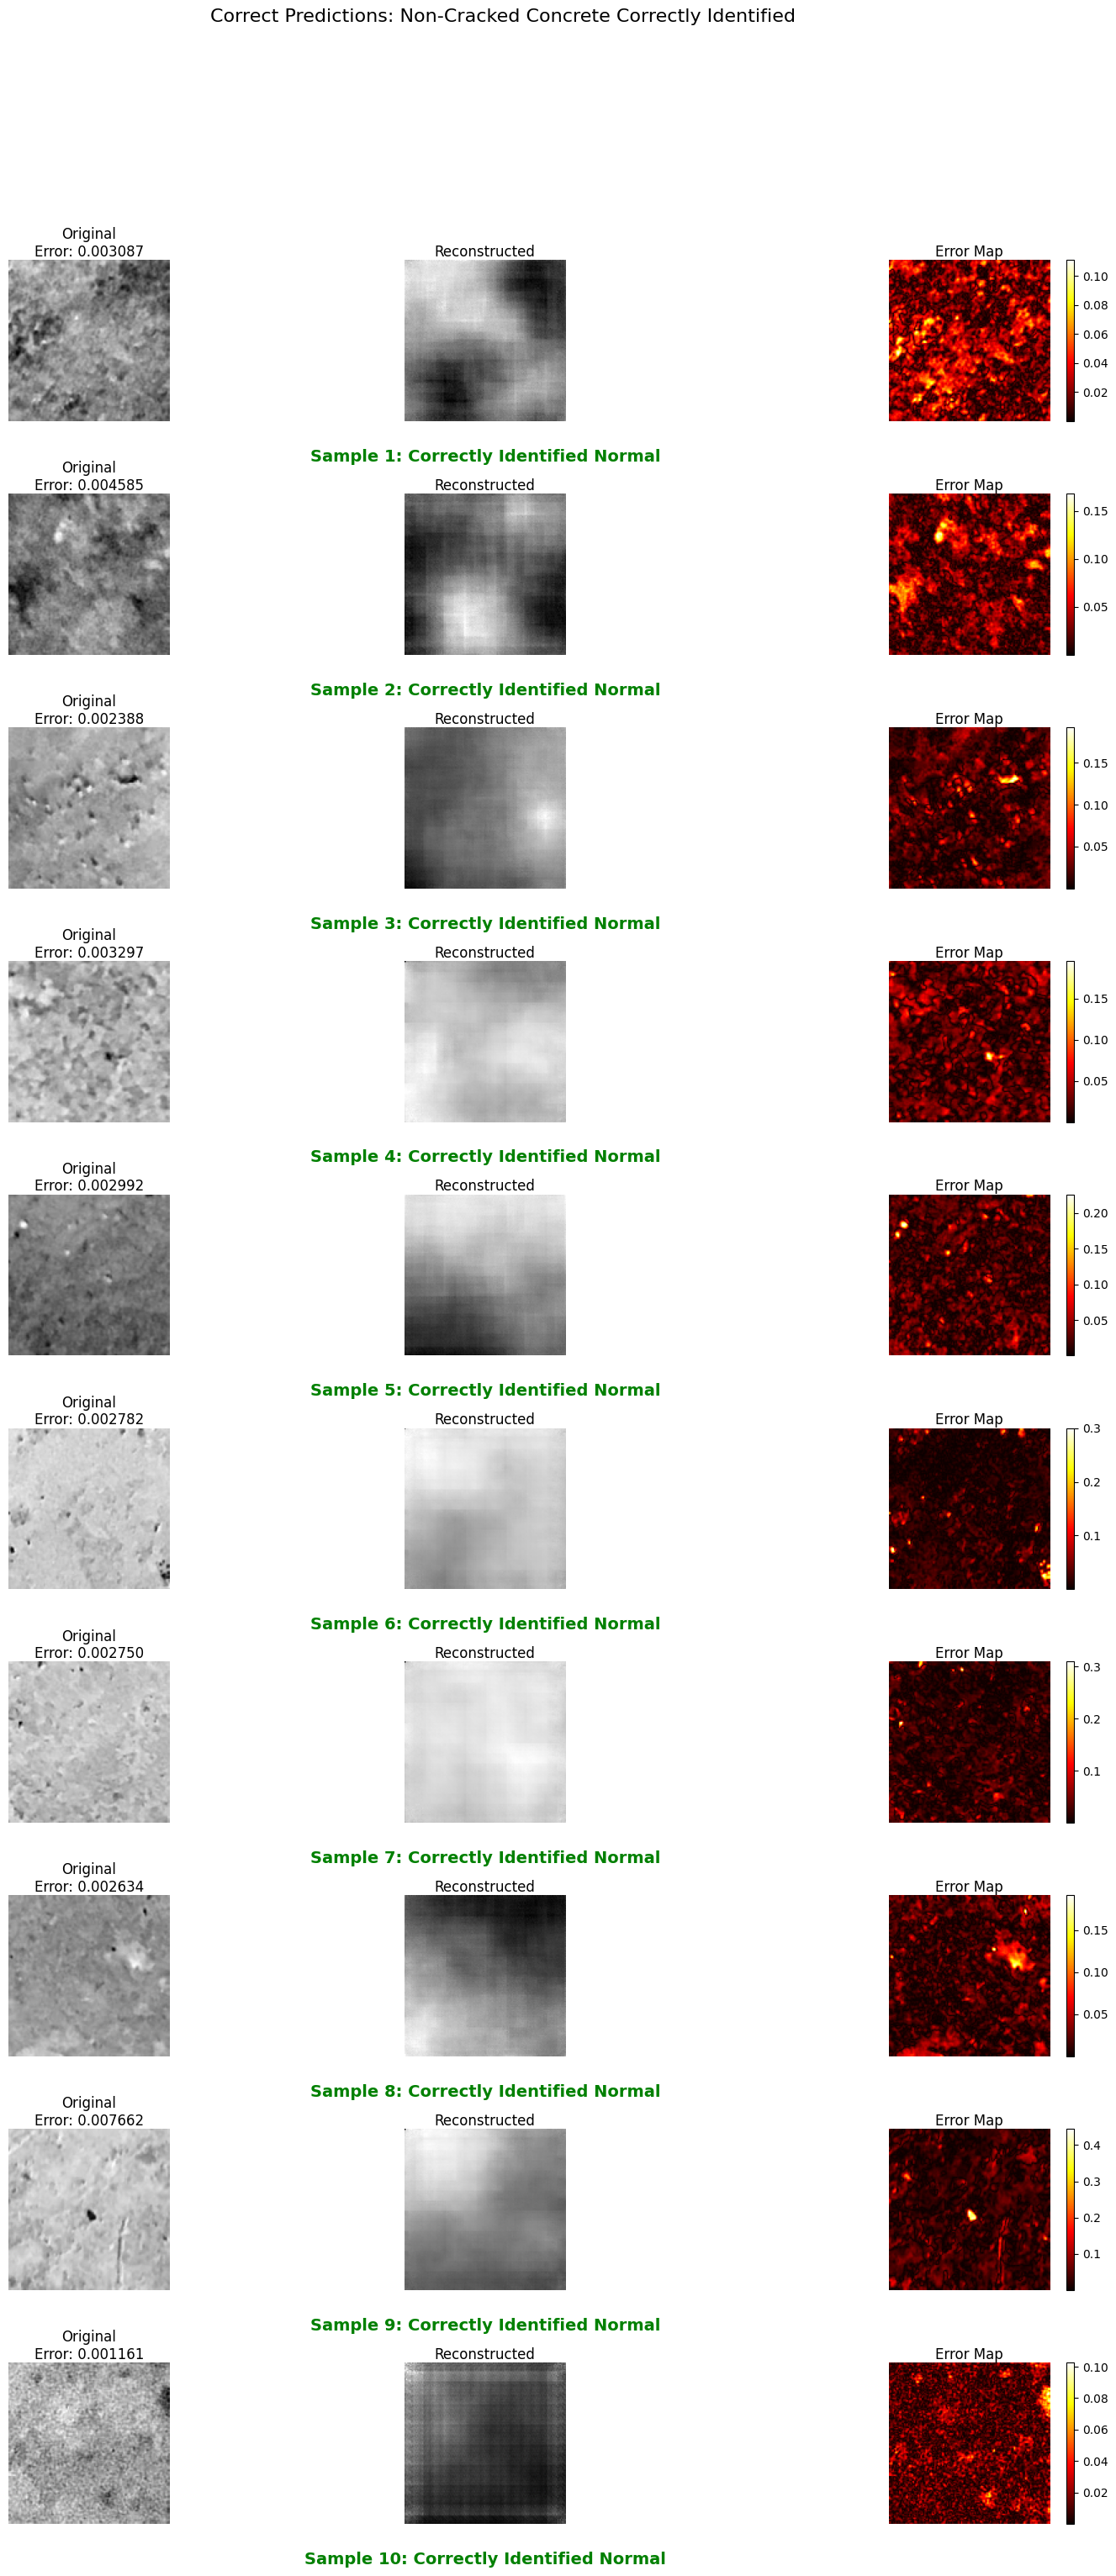

In [ ]:
# @title **Visualizing Correctly Predicted Non-Cracked Examples**
print("\n📌 Visualizing Correctly Predicted Non-Cracked Examples:")
visualize_correct_predictions(dl_test_non, loaded_vae, threshold, device,
                              "Non-Cracked Concrete Correctly Identified", is_anomaly=False)


📌 Visualizing Correctly Predicted Cracked Examples:


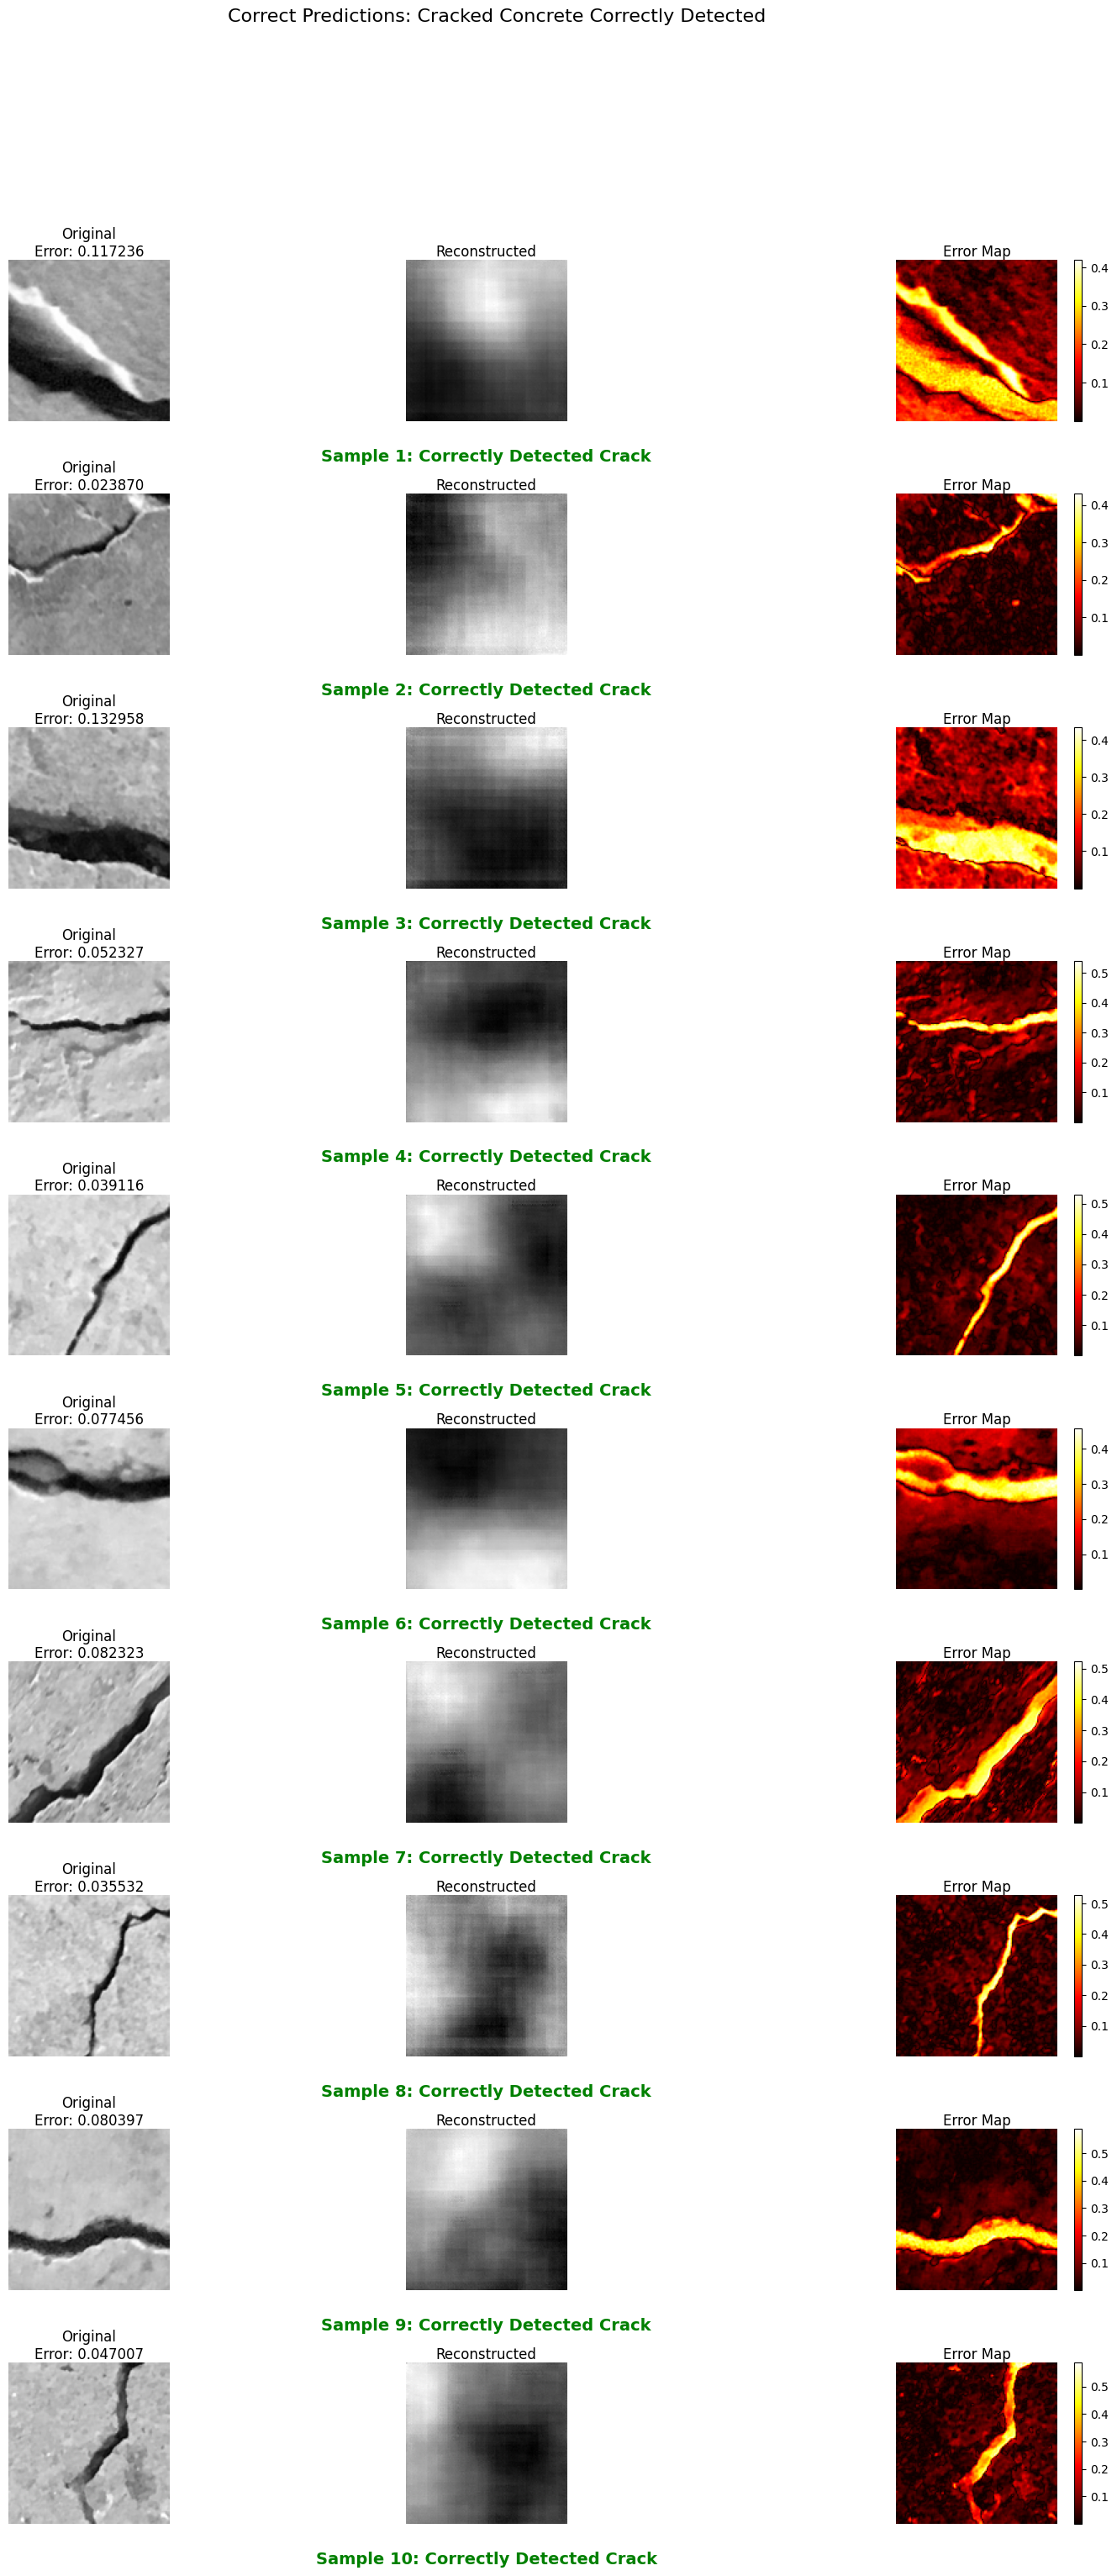

In [ ]:
# @title **Visualizing Correctly Predicted Cracked Examples**
print("\n📌 Visualizing Correctly Predicted Cracked Examples:")
visualize_correct_predictions(dl_test_crack, loaded_vae, threshold, device,
                              "Cracked Concrete Correctly Detected", is_anomaly=True)




📌 Analyzing False Positives (Normal misclassified as Cracked):


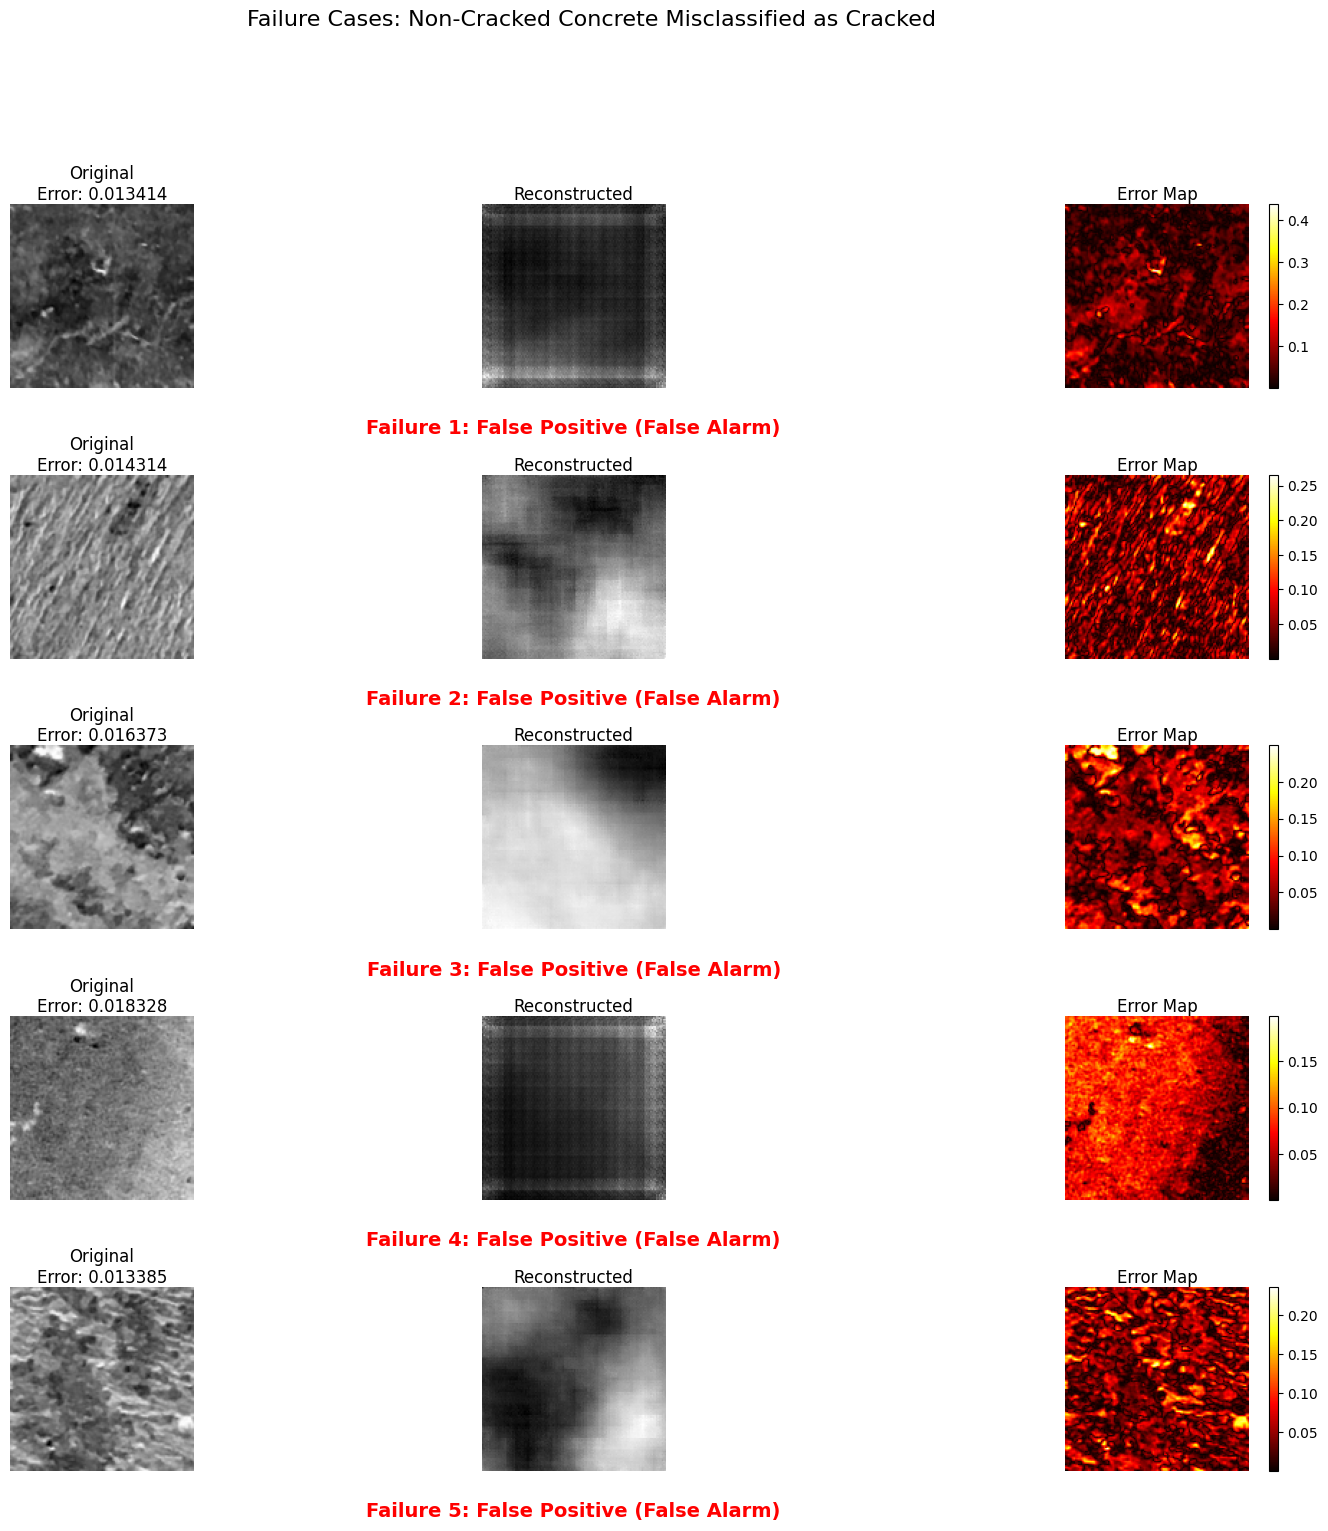

In [ ]:
# @title **Analyzing False Positives (Normal misclassified as Cracked)**
print("\n📌 Analyzing False Positives (Normal misclassified as Cracked):")
analyze_failures(dl_test_non, loaded_vae, threshold, device,
                 "Non-Cracked Concrete Misclassified as Cracked", is_anomaly=False)




📌 Analyzing False Negatives (Cracked misclassified as Normal):


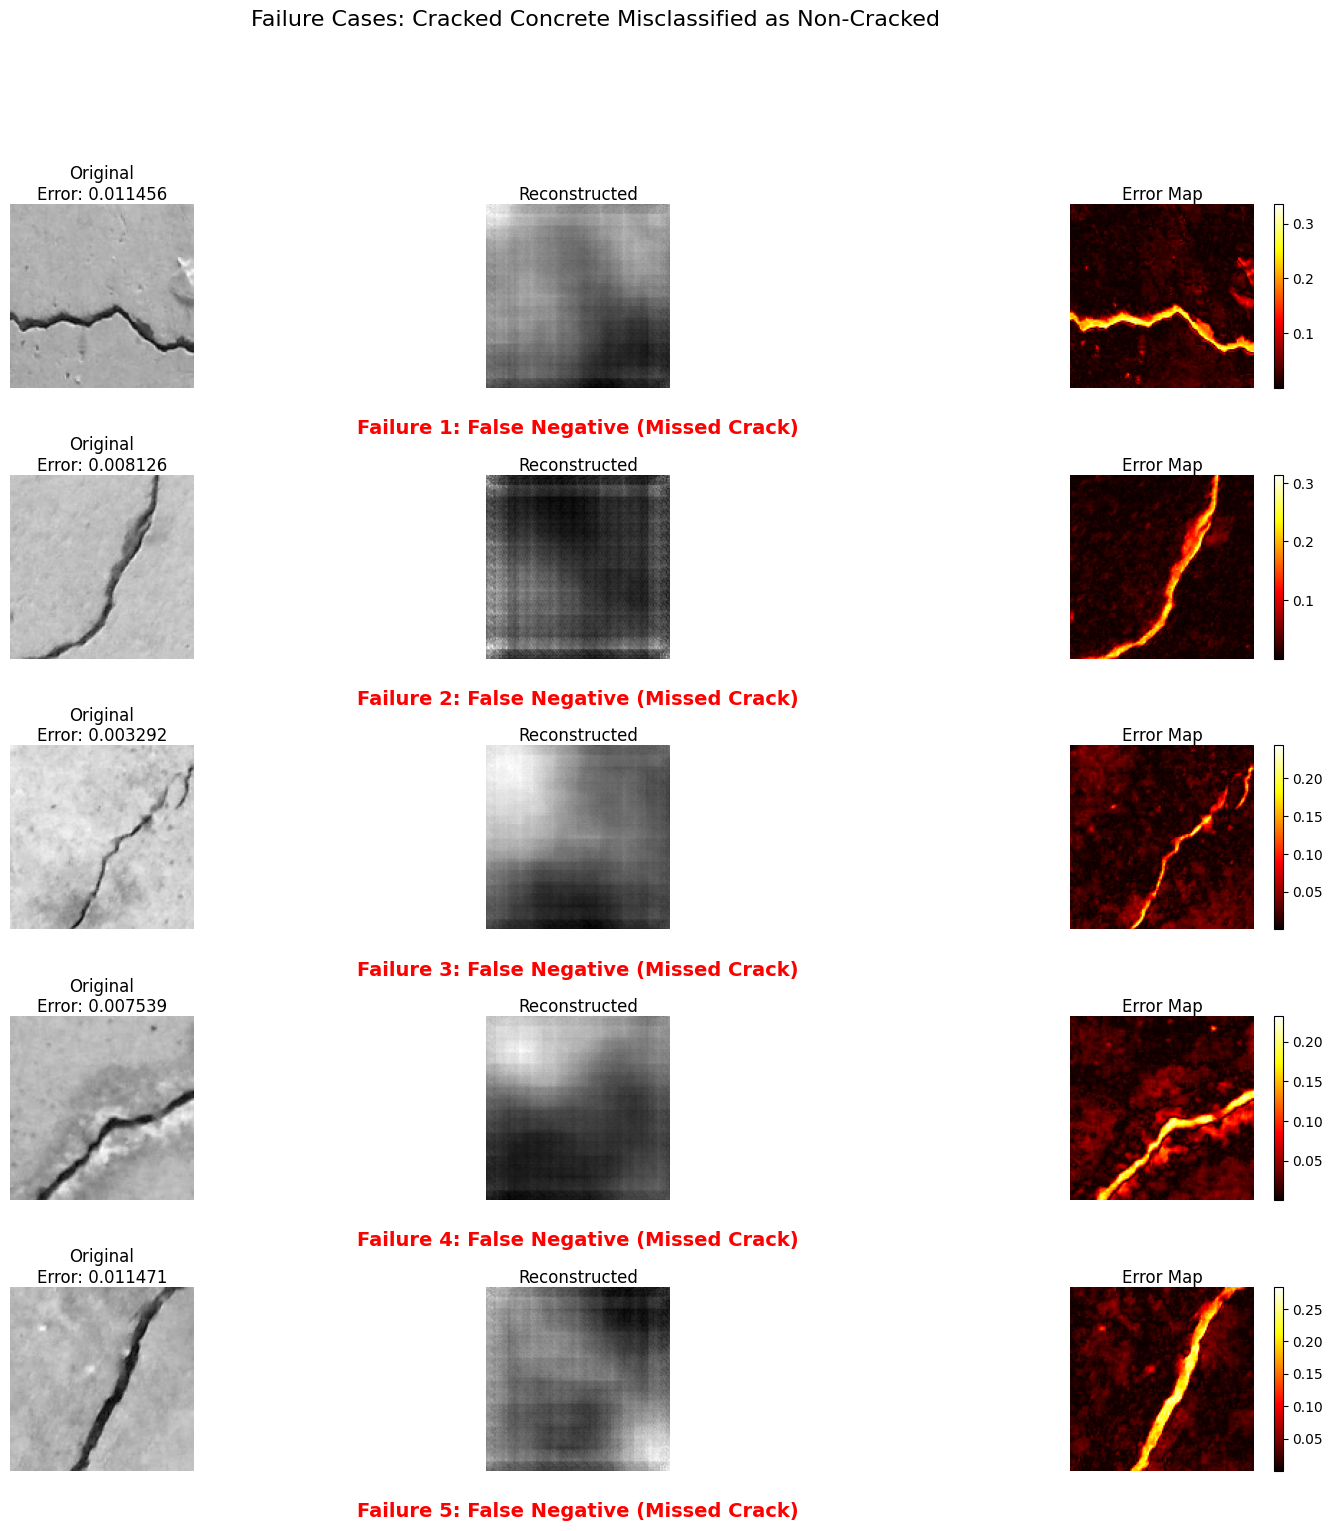

In [ ]:
# @title **Analyzing False Negatives (Cracked misclassified as Normal)**
print("\n📌 Analyzing False Negatives (Cracked misclassified as Normal):")
analyze_failures(dl_test_crack, loaded_vae, threshold, device,
                 "Cracked Concrete Misclassified as Non-Cracked", is_anomaly=True)
